# Import libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import math
import imp
import numpy as np
import tensorflow as tf
import os
import time
import dataprocessing as dp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from Models_3DRFB_Attention_Multilayer import Model_3D
from Parts import *
import easydict
import csv
import pandas as pd

from sklearn.metrics import accuracy_score

# Main Function


Current cuda device  0
lead phase : [1/2]
ensemble phase : [1/1]
torch.Size([456, 23])
(456,)
0.9030094261372598
Save prediction: lead = 0


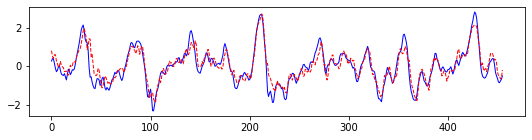

0.8960489165237853
Save prediction: lead = 1


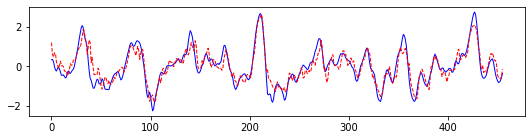

0.858342189950744
Save prediction: lead = 2


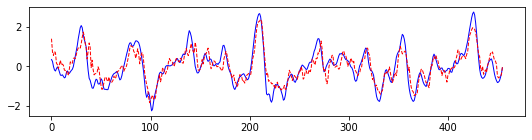

0.8166504740951216
Save prediction: lead = 3


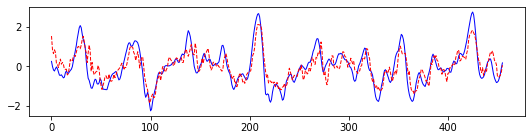

0.7703794285327095
Save prediction: lead = 4


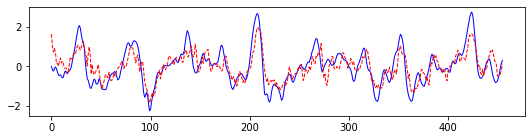

0.7223948876294365
Save prediction: lead = 5


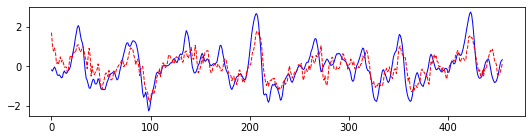

0.6778663927151144
Save prediction: lead = 6


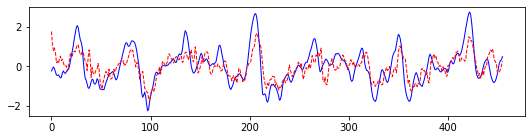

0.6428032848526685
Save prediction: lead = 7


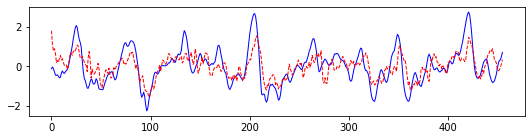

0.6179728592577282
Save prediction: lead = 8


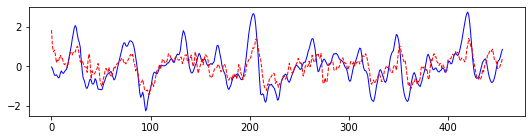

0.5952257435648938
Save prediction: lead = 9


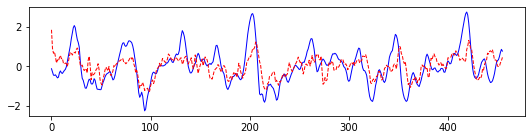

0.563393840097563
Save prediction: lead = 10


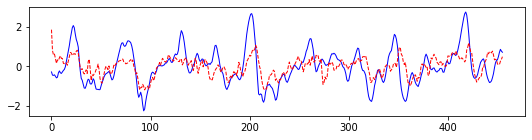

0.5219081994727716
Save prediction: lead = 11


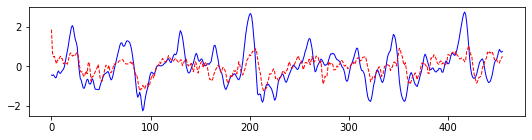

0.4788984175677827
Save prediction: lead = 12


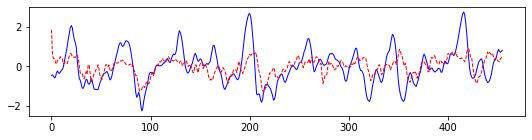

0.44283498325540216
Save prediction: lead = 13


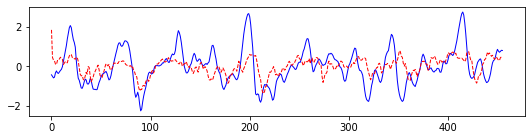

0.41729113559016745
Save prediction: lead = 14


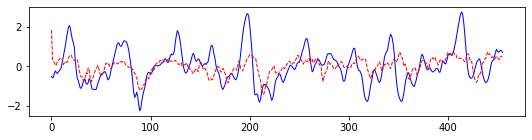

0.40239367296100975
Save prediction: lead = 15


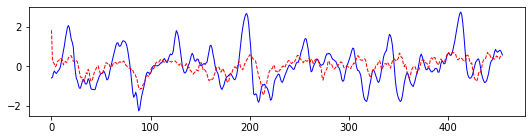

0.3931166589230464
Save prediction: lead = 16


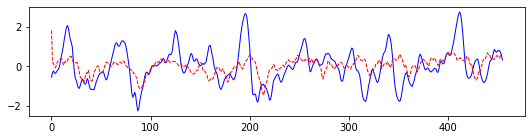

0.38716525379502026
Save prediction: lead = 17


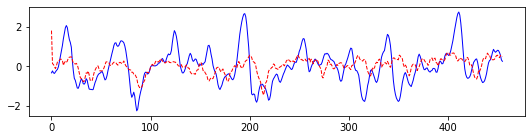

0.381612162618427
Save prediction: lead = 18


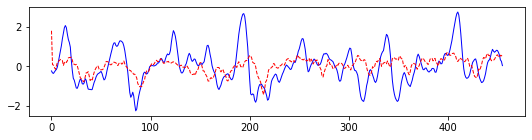

0.3789409183105829
Save prediction: lead = 19


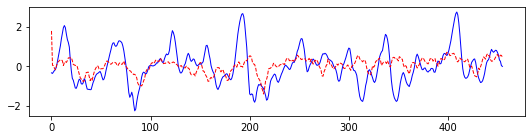

0.3776614352189809
Save prediction: lead = 20


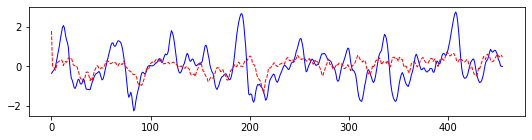

0.3746548107120571
Save prediction: lead = 21


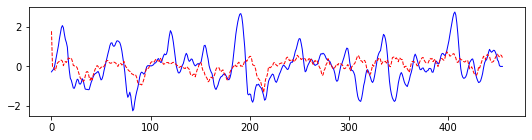

0.3665369294318679
Save prediction: lead = 22


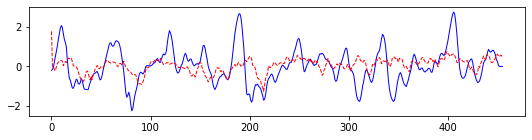

Save classification: lead = 22


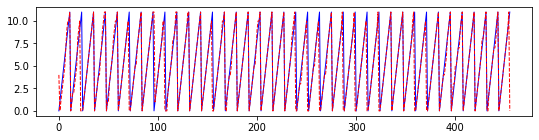

Accuracy = [0.82894737]


In [2]:
if __name__ == "__main__":
    # Random seed 
    # torch.backends.cudnn.deterministic = True 
    # torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)

    # Arguments
    args = easydict.EasyDict({
        "startLead": 1,
        "endLead": 2,
        "gpu": 0,
        "input": 3
    })

    # Directories
    # Dataset for pretrain
    Folder = "./pretrain_3DRFB_Attention_Multilayer_3/"
    dataFolder = "./"

#     # Dataset for finetuning
#     Folder = "./finetuning_3DRFB_Attention_3"
#     dataFolder = "./"
    
    SSTFile_val = dataFolder+'/Data_validation/godas.input.1980_2017.nc'
    SSTFile_val_label = dataFolder+'/Data_validation/godas.label.1980_2017.nc'

    device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(device) # change allocation of current GPU
    print ('Current cuda device ', torch.cuda.current_device()) # check

    # Set Hyper-parameters
    regularizer_rate = 0.001  #L2 regularization
    batch_size = 1              # batch size
    numEpoch =  40              # No. Epoch
    learning_rate = 0.0001      # Initial Learning Rate
    n_cycles = 4                # No. cycles in Cosine Annealing
    epochs_per_cycle = math.floor(numEpoch / n_cycles)  # No. epochs for each cycle

    dr = 0.0                    # Dropout rate for Bayesian learning
    tau = 1.0                   # Weight for the batch size in regularization weight calculation (Bayesian learning)
    lengthscale = 1e-2          # Default regularization weight (L2)
    reg = lengthscale**2 * (1 - dr) / (2. * batch_size * tau) # L2 regularization weight for Bayesian learning
    noF = 16                    # Initial No. filters
    num_layer = 128             # Feature size of 1st fully-connected layer
    num_answer = 2              # No. answers(3=3.4/ep/cp)

    ENS_Start = 0
    ENS = 1
    # loop - 1 time only
    for lead in range(args.startLead, args.endLead) :
        print('lead phase : [{}/{}]'.format(lead, args.endLead))

        # Dataset for training
        valset = datasets_general_3D_alllead(SSTFile_val, SSTFile_val_label, lead, sstName='sst', hcName='t300', labelName='pr', noise = False)
        testloader = DataLoader(valset, batch_size = len(valset), shuffle=False)
        test_step = len(testloader)
        assemble_real_nino = []
        assemble_real_type = []
        assemble_pred_nino = []
        assemble_pred_type = []
        for ens in range(ENS_Start, ENS) :
            print('ensemble phase : [{}/{}]'.format(ens+1, ENS))

            model = Model_3D(2, noF, num_layer, num_answer, dr, args.input).to(device)
            model.load_state_dict(torch.load('{}/train_{}_{}/train_{}_{}.pth'.format(Folder, lead, ens, lead, ens)))
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=regularizer_rate, betas=(0.9, 0.999))
            model.eval()
            
            bayesianIter = 1
            uncertaintyarry_nino = np.zeros((bayesianIter, len(valset), 23))
            uncertaintyarry_type = np.zeros((bayesianIter, len(valset), 12))

            with torch.no_grad() :
                for i, (batch, ansnino, anstype) in enumerate(testloader):
                    batch = Variable(batch.float().cuda())
                    ansnino = Variable(ansnino.float().cuda())
                    anstype = Variable(anstype.float().cuda())
                    for b in range(int(bayesianIter)):
                        output = model(batch) # inference
                        # print(output[1].shape)
                        prednino = np.squeeze(output[0], axis=2)
                        uncertaintyarry_nino[b, :, :] = prednino.cpu()
                        # print(uncertaintyarry_nino[b, :])
                        uncertaintyarry_type[b, :, :] = torch.nn.functional.softmax(output[1], dim=1).cpu()

                    print(ansnino.shape)
                    assemble_real_nino.append(ansnino.cpu().numpy())
                    anstype = torch.argmax(anstype, dim=1).cpu().numpy()
                    # print(anstype.shape)
                    assemble_real_type.append(anstype)

                    # for j in range(len(testloader)):
                    assemble_pred_nino.append(np.mean(uncertaintyarry_nino, axis=0))
                    # print(np.mean(uncertaintyarry_nino, axis=0).shape)
                    predMean = np.mean(uncertaintyarry_type, axis = 0)
                    # print(predMean.shape)
                    assemble_pred_type.append(np.argmax(predMean, axis = 1))  

                    del batch
                    del ansnino
                    del anstype
            
            # calculate correlation skill
            assemble_real_nino = assemble_real_nino[0] # 463 x 23 (test length x lead time)
            assemble_pred_nino = assemble_pred_nino[0] # 463 x 23 (test length x lead time)
            assemble_real_type = assemble_real_type[0] # 463  (test length) = 0 ~ 11 Calendar Month
            assemble_pred_type = assemble_pred_type[0] # 463  (test length) = 0 ~ 11 Calendar Month
            
            
            print(assemble_real_type.shape)
            corr = np.zeros(23)
            for i in range(23):
                corr[i] = dp.CorrelationSkill(assemble_real_nino[:, i], assemble_pred_nino[:, i])
                print(corr[i])
                print('Save prediction: lead = {}'.format(i) )
                inputTimeSeq = assemble_real_nino.shape[0]
                dwidth = 800
                dpi = 90
                dheight = 180
                plt.figure(figsize=(dwidth/dpi, dheight/dpi))
                timeValues = np.arange(0, inputTimeSeq)
                plt.plot(timeValues, assemble_real_nino[:, i], marker='', color='blue', linewidth=1, label="Measurement")
                plt.plot(timeValues, assemble_pred_nino[:, i], marker='', color='red', linewidth=1, linestyle='dashed', label="Prediction")
                plt.savefig(Folder + "/NinoPred_" + str(i).zfill(6) + ".png", orientation='landscape', bbox_inches='tight')
                plt.show()
                plt.close()
            
            np.savetxt(Folder + '/correlation.csv',corr,delimiter=",")
            
            print('Save classification: lead = {}'.format(i) )
            plt.figure(figsize=(dwidth/dpi, dheight/dpi))
            timeValues = np.arange(0, inputTimeSeq)
            plt.plot(timeValues, assemble_real_type, marker='', color='blue', linewidth=1, label="Measurement")
            plt.plot(timeValues, assemble_pred_type, marker='', color='red', linewidth=1, linestyle='dashed', label="Prediction")
            plt.savefig(Folder + "/Month_Classification" + ".png", orientation='landscape', bbox_inches='tight')
            plt.show()
            plt.close()
            accuracy = np.zeros(1)
            accuracy[0] = accuracy_score(assemble_real_type, assemble_pred_type)
            print('Accuracy = {}'.format(accuracy))
            np.savetxt(Folder + '/accuracy.csv',accuracy,delimiter=",")


        # print(assemble_pred_nino)
        np.save("{}/lead_{}_assemble_real_nino".format(Folder, lead), assemble_real_nino) # 길이가 valset인 것이 ensemble 갯수 만큼 들어있음
        np.save("{}/lead_{}_assemble_real_type".format(Folder, lead), assemble_real_type)
        np.save("{}/lead_{}_assemble_pred_nino".format(Folder, lead), assemble_pred_nino)
        np.save("{}/lead_{}_assemble_pred_type".format(Folder, lead), assemble_pred_type)

